## PULSO Tutorial

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from annoy import AnnoyIndex
from scipy.sparse import csr_matrix

In [2]:
def _gini(array):
    """Calculate the Gini coefficient of a numpy array.
    """
    
    array = array.flatten().astype(float)
    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 0.0000001
    array = np.sort(array)
    index = np.arange(1, array.shape[0]+1)
    n = array.shape[0]
    array_sum = np.sum(array)
    return (2 * np.dot(index, array) - (n + 1) * array_sum) / (n * array_sum)

In [3]:
def _knn(X_ref,
         X_query=None,
         k=20,
         leaf_size=40,
         metric='euclidean',
         annoy_n_trees=10):
    """Calculate K nearest neighbors for each row, using KDTree or Annoy.
    """
    if X_query is None:
        X_query = X_ref.copy()
    dim = X_ref.shape[1]
    if dim < 8192:
        kdt = KDTree(X_ref, leaf_size=leaf_size, metric=metric)
        kdt_d, kdt_i = kdt.query(X_query, k=k, return_distance=True)   
    else:
        annoy_index = AnnoyIndex(dim, metric)
        #Add all points from X_ref to Annoy index --> change algorithm
        for i in range(X_ref.shape[0]):
            annoy_index.add_item(i, X_ref[i])
        annoy_index.build(annoy_n_trees)
        kdt_i = []
        kdt_d = []
        for x in X_query:
            indices, distances = annoy_index.get_nns_by_vector(x, k, include_distances=True)
            kdt_i.append(indices)
            kdt_d.append(distances)
        kdt_i = np.array(kdt_i)
        kdt_d = np.array(kdt_d)

    sp_row = np.repeat(np.arange(kdt_i.shape[0]), kdt_i.shape[1])
    sp_col = kdt_i.flatten()
    sp_conn = np.repeat(1, len(sp_row))
    sp_dist = kdt_d.flatten()
    mat_conn_ref_query = csr_matrix(
        (sp_conn, (sp_row, sp_col)),
        shape=(X_query.shape[0], X_ref.shape[0])).T
    mat_dist_ref_query = csr_matrix(
        (sp_dist, (sp_row, sp_col)),
        shape=(X_query.shape[0], X_ref.shape[0])).T
    return mat_conn_ref_query, mat_dist_ref_query

## Toy example

In [4]:
import pandas as pd
import numpy as np
import math
import scipy as sp

import matplotlib.pyplot as plt

In [5]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=7)
points = pd.DataFrame(x, y).reset_index(drop=True)
points.columns = ["x", "y"]
points.head()

,x,y
0,-8.774028,4.418394
1,8.619511,0.638642
2,-9.216388,6.670846
3,-8.474725,3.843652
4,8.189931,1.501072


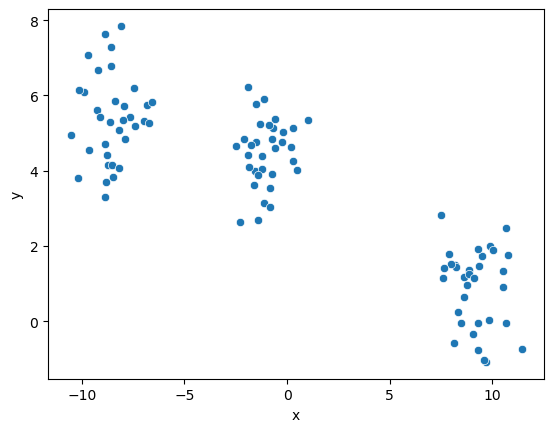

In [6]:
import seaborn as sns
sns.scatterplot(x="x", y="y", data=points, palette="Set2");

In [7]:
import matplotlib.pyplot as plt

def get_cmap(n, name='viridis'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(3)

/tmp/ipykernel_716367/2905716801.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


#### k-means

In [8]:
#fitting model
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 3, random_state = 10)
model.fit(points)
kmeans_labels = model.fit_predict(points)
points['cluster'] = kmeans_labels

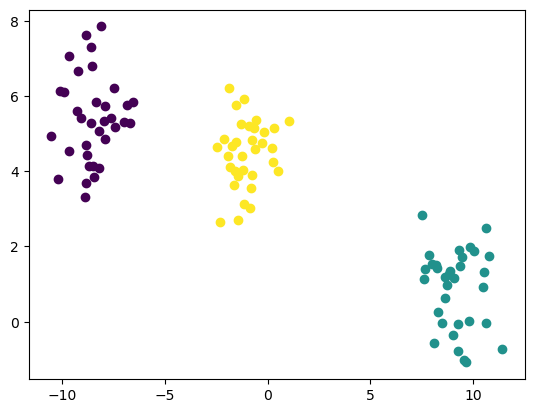

In [9]:
#plotting
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(len(points)):
    plt.plot([points['x'][i]], [points['y'][i]], marker='o', color=cmap(points['cluster'][i]))

#### Gaussian mixture

In [10]:
#fitting model
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(points)

points['cluster'] = gmm_labels

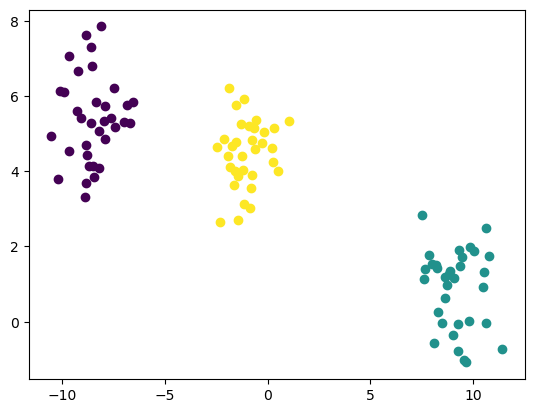

In [11]:
#plotting
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(len(points)):
    plt.plot([points['x'][i]], [points['y'][i]], marker='o', color=cmap(points['cluster'][i]))

#### hierarchical clustering

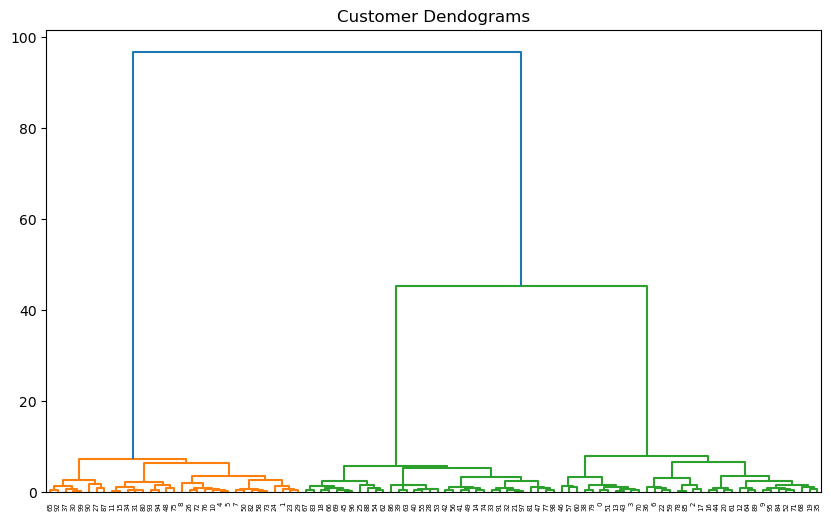

In [12]:
#Dendrogram
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 6))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(points, method='ward'))

In [13]:
#fitting model
from sklearn.cluster import AgglomerativeClustering

hierachical_fit = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hac_labels = hierachical_fit.fit_predict(points)

points['cluster'] = hac_labels

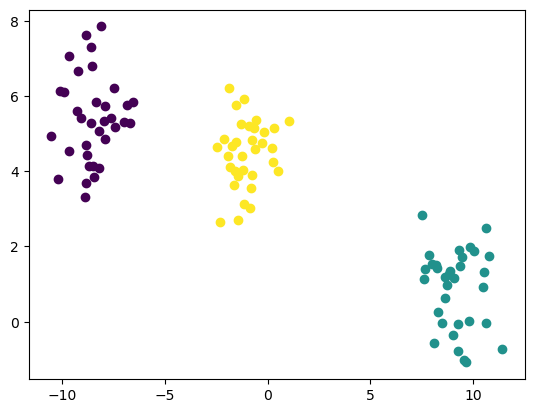

In [14]:
#plotting
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(len(points)):
    plt.plot([points['x'][i]], [points['y'][i]], marker='o', color=cmap(points['cluster'][i]))

## else

![Sample Image](https://i.pinimg.com/564x/88/67/a4/8867a454935fa63595614875e48a6b53--samoyed-funny-samoyed-dogs.jpg)

![Sample Image](https://i.imgur.com/eHUVAtr.gif)

[GOOGLE](https://google.com)

[Image]: https://picsum.photos/500/300 "This is an image!"